# CODEX, scRNAseq comparison NOV2022

In [1]:
import scanpy as sc
from tidyverse.dummy import *
from sctools import pipeline
from sctools.scplotting import kneeplot_split, recolor
from sctools.de import gene_expression_to_flat_df_NEW, scanpy_DE_to_dataframe_fast, get_de_genes
from crukiopy_release.datatools import read_metadata, fix_diagnosis, diagnosis_fix_dict
from crukiopy_release.colormaps import celltype_order_coarse_celltype, color_dict_diagnosis, cmap_subtypes, color_dict_coarse_celltype
import scHCLpy.adata
import gc
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod
from crukiopy_release.codex import load_sample, iterate_codex_adatas, INV_coarse_CT_dict, INV_coarse_CT_dict2, matt_diagnosis_dict, invert_dict
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
from crukiopy_release.celltype_mappings import annotate_coarse_celltype, annotate_epi_stroma_immune

Importing tidyverse


adjusting celltype colors

In [2]:
color_dict_coarse_celltype['Columnar Epithelium'] = color_dict_coarse_celltype['Epithelial cells']
color_dict_coarse_celltype['Squamous Epithelium'] = '#025b02'
color_dict_coarse_celltype['Myeloid'] = color_dict_coarse_celltype['Macrophages']
color_dict_coarse_celltype['Myofibroblasts'] = '#005eb7'

celltypes to plot

In [3]:
consensus_types = [
    'Columnar Epithelium',
    'Squamous Epithelium',    
    'Tcells',
    'Bcells',
    'Myeloid',
    'Fibroblasts',
    'Myofibroblasts',
    'Endothelial cells',    
]

# Create data

the original full dataset is located here:
```gsutil -m cp gs://cruk-adata-for-cellbrowser/Aug2022_adata/Atlas/Eso_Atlas.h5ad .```

In [4]:
adata = sc.read_h5ad('/home/mstrasse/TB4/Aug2022_adata/Atlas/Eso_Atlas.h5ad')

# Stringent filtering!!
adata = adata[adata.obs.doublet_score<0.2]
adata = adata[adata.obs.percent_mito<0.1]

# fixing some diagnosis
adata = fix_diagnosis(adata)
# recolor(adata, 'diagnosis', color_dict_diagnosis)

adata = adata[adata.obs.diagnosis.isin(['NE', 'NS', 'M','D','T'])]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.obs` of view, copying.


adding the above consensus celltypes to scRNAseq

In [6]:
adata.obs['celltype_split'] = annotate_coarse_celltype(adata, cluster_field='leiden')
adata.obs['celltype_split'] = adata.obs['celltype_split'].astype(str)

adata.obs.loc[adata.obs.celltype_split=="Epithelial cells",'celltype_split'] = 'Columnar Epithelium'
adata.obs.loc[adata.obs.celltype_split=="Macrophages",'celltype_split'] = 'Myeloid'
adata.obs.loc[adata.obs.leiden.isin(['20','18','17']),'celltype_split'] = 'Squamous Epithelium'
adata.obs.loc[adata.obs.leiden=="13", 'celltype_split'] = 'Myofibroblasts'

df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(adata.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    if s in df_meta.index:
        df_meta.loc[s, 'diagnosis'] = d

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'diagnosis' as categorical
... storing 'sample_diagnosis' as categorical
... storing 'celltype_split' as categorical


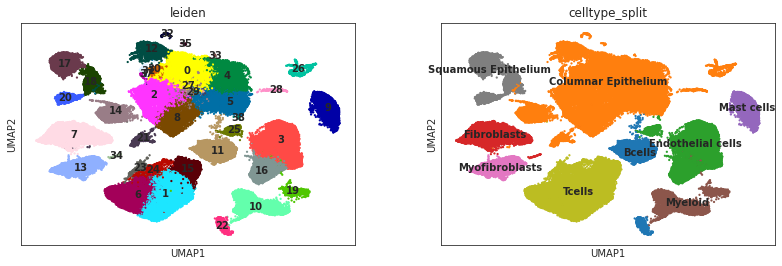

In [7]:
set_matplotlib_formats('png')
sc.pl.umap(adata, color=['leiden', 'celltype_split'], legend_loc='on data', size=20)

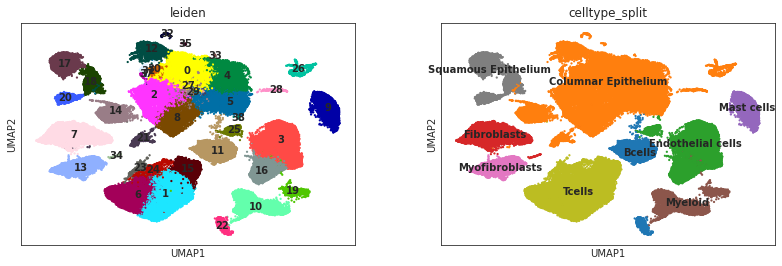

In [8]:
set_matplotlib_formats('png')
sc.pl.umap(adata, color=['leiden', 'celltype_split'], legend_loc='on data', size=20)

In [9]:
recolor(adata, 'celltype_split', color_dict_coarse_celltype)

### filter out any cells not in the consensus, i.e. mast cells

In [10]:
adata = adata[adata.obs.celltype_split.isin(consensus_types)]

# Proportions as in CODEX

## Annotate the subtypes
### Tcell

In [ ]:
_a = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/Tcell_processed.h5ad')
sc.pl.umap(_a, color=['leiden','CD4', 'FOXP3'], legend_loc='on data', size=20)

In [ ]:
Tcells_ix = {
    'Treg': _a.obs.query('leiden=="3"').index.values,
    'Thelper': _a.obs.query('leiden in ["1", "2"]').index.values,
    'cytoTcell': _a.obs.query('leiden in ["0", "4"]').index.values
}
Tcells_ix['other_Tcells'] = list(set( _a.obs.index) - set.union(*[set(_) for _ in Tcells_ix.values()]))

### Bcell

In [ ]:
_a = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/Bcell_processed.h5ad')
sc.pl.umap(_a, color=['leiden','CD4', 'FOXP3'], legend_loc='on data', size=20)

In [ ]:
Bcells_ix = {
    'Bcells': _a.obs.query('leiden=="2"').index.values,
}
Bcells_ix['Plasma'] = list(set( _a.obs.index) - set.union(*[set(_) for _ in Bcells_ix.values()]))

In [ ]:
_a = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/Myeloid_processed.h5ad')
sc.pl.umap(_a, color=['leiden'], legend_loc='on data', size=20)

### Myeloid

In [ ]:
myeloid_ix = {
    'Neutrophil': _a.obs.query('leiden in ["3","7"]').index.values,
    'DC': _a.obs.query('leiden in ["4"]').index.values,
}
myeloid_ix['Macrophages'] = list(set( _a.obs.index) - set.union(*[set(_) for _ in myeloid_ix.values()]))

In [ ]:
sc.pl.umap(adata, color=['leiden', 'celltype_split'], legend_loc='on data', size=20)

In [ ]:
### Other stuff
other_ix = {
    'SMC': adata.obs.query('leiden=="13"').index.values,
    'Lymph': adata.obs.query('leiden=="25"').index.values,
    'Other': adata.obs.query('nobatch_leiden=="48"').index.values,   # nerve
}

In [18]:
all_ix = {}
all_ix.update(Tcells_ix)
all_ix.update(Bcells_ix)
all_ix.update(myeloid_ix)
all_ix.update(other_ix)

inverted_dict = {}
for k, vlist in all_ix.items():
    for v in vlist:
        inverted_dict[v] = k

In [19]:
adata.obs['celltype_split_codex'] = adata.obs.index.map(lambda x: inverted_dict[x] if x in inverted_dict else '@')
adata.obs.loc[adata.obs.celltype_split_codex=="@", 'celltype_split_codex'] = adata.obs.loc[adata.obs.celltype_split_codex=="@", 'celltype_split']

In [20]:
adata.obs.loc[adata.obs.celltype_split_codex=="Tcells", 'celltype_split_codex'] = 'other_Tcells'

KeyError: 'Could not find key celltype_split_codex in .var_names or .obs.columns.'

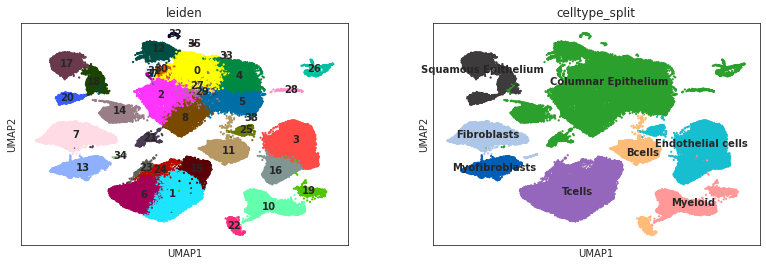

In [83]:
sc.pl.umap(adata, color=['leiden', 'celltype_split', 'celltype_split_codex'], legend_loc='on data', size=20)
plt.figure(figsize=(10,10))
sc.pl.umap(adata, color=['celltype_split_codex'], legend_loc='on data', size=20, ax=plt.gca())

## scCODA
### full scRNAseq data

In [11]:
cluster_name = 'celltype_split'

In [12]:
a_tmp = adata

data_scanpy_1 = dat.from_scanpy(
    a_tmp,
    cell_type_identifier=cluster_name,
    sample_identifier="samplename",
    covariate_df=df_meta[df_meta.index.isin(a_tmp.obs.samplename.unique())]
)

In [13]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

In [14]:
# need to extend cmap by one
from crukiopy_release.colormaps import cmap_subtypes, ListedColormap

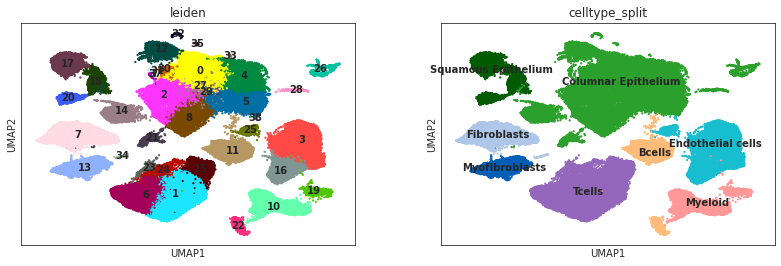

In [15]:
set_matplotlib_formats('png')
sc.pl.umap(adata, color=['leiden', 'celltype_split'], legend_loc='on data', size=20)

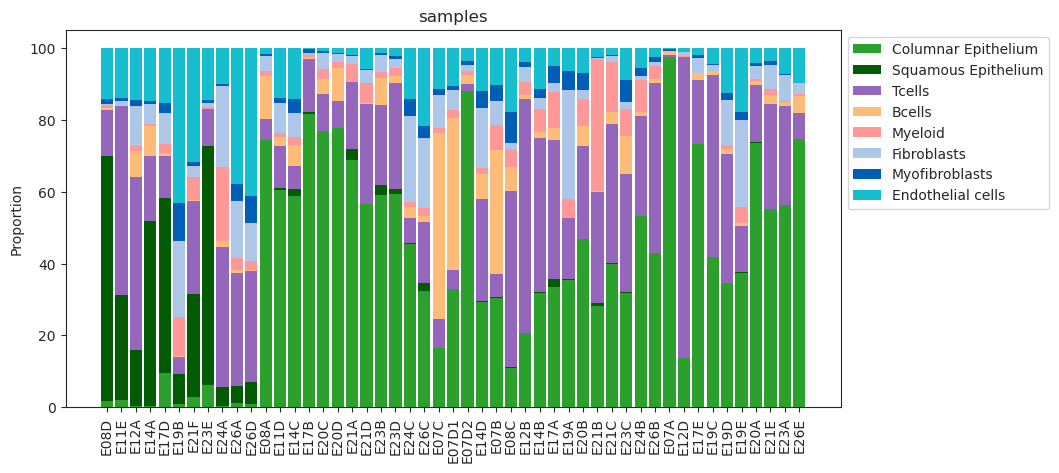

In [16]:
order = []
for d in diagnosis_ordered:
    order.extend(sorted(df_meta.query('diagnosis==@d').index))

leiden_color_dict = dict(zip(data_scanpy_1.var.index, adata.uns[f'{cluster_name}_colors'] ))
cmap_reordered_by_consensus = ListedColormap([leiden_color_dict[c] for c in consensus_types])   
    
set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, consensus_types], 
                          feature_name="samples", 
                          figsize=(10,5), 
                          cmap=cmap_reordered_by_consensus, 
                          level_order=order)
plt.xticks(rotation=90);
set_matplotlib_formats('png')

# fig.figure.savefig(f'{plotfolder}/Tcell_proportions_per_sample.svg')

In [18]:
plotfolder = '/tmp'

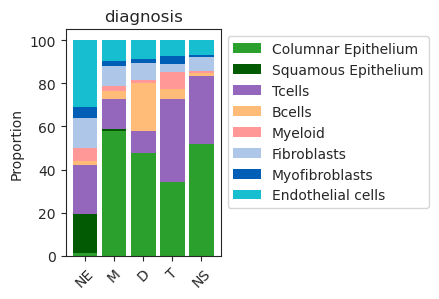

In [19]:
# set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, consensus_types], 
                          feature_name="diagnosis", 
                          level_order=diagnosis_ordered, 
                          cmap=cmap_reordered_by_consensus, figsize=(2,3))
fig.figure.savefig(f'{plotfolder}/codex_scrnaseq_compare_rnaseq_diag.svg')
set_matplotlib_formats('png')

### restrict it to the CODEX sample

In [20]:
codex_patients = ['E08', 'E11', 'E12', 'E17', 'E19', ]

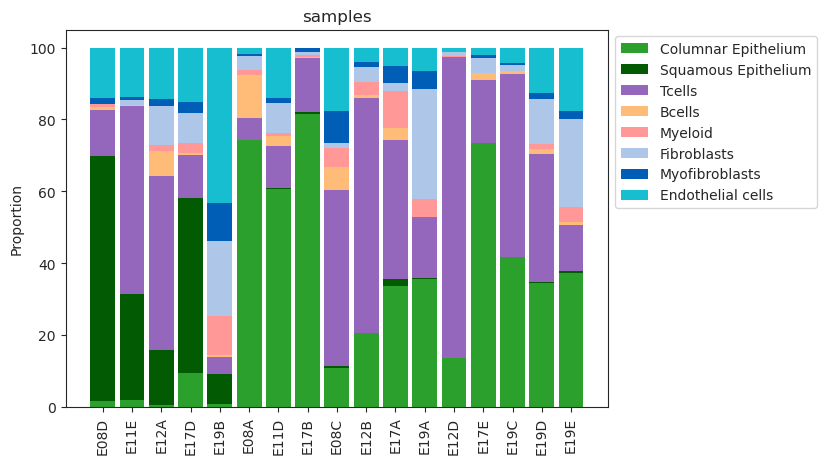

In [26]:
order = []
for d in diagnosis_ordered:
    order.extend(sorted(df_meta.query('diagnosis==@d and patient in @codex_patients').index))

data_scanpy_1_codex_patients = data_scanpy_1[data_scanpy_1.obs.patient.isin(codex_patients), consensus_types]
    
set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1_codex_patients, 
                          feature_name="samples", figsize=(7,5), cmap=cmap_reordered_by_consensus, level_order=order)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/codex_scrnaseq_compare_rnaseq_samples.svg')
set_matplotlib_formats('png')

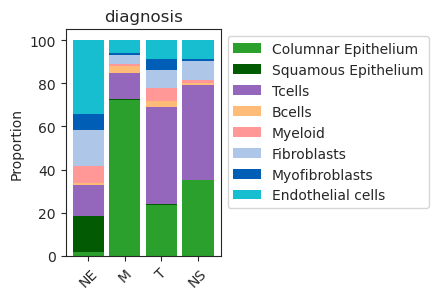

In [23]:
# set_matplotlib_formats('svg')
fig = viz.stacked_barplot(
    data_scanpy_1_codex_patients, 
    feature_name="diagnosis", 
    level_order=[_ for _ in diagnosis_ordered if _ in data_scanpy_1_codex_patients.obs.diagnosis.values],
    cmap=cmap_reordered_by_consensus, figsize=(2,3))
fig.figure.savefig(f'{plotfolder}/codex_scrnaseq_compare_rnaseq_diag.svg')

# CODEX
get the adatas from cloud storage 

`gsutil -m cp -r gs://mstrasse_tmp_data/CODEX_adata /home/mstrasse/TB4`

Adjust `codex_path` accordingly below

loading codex data from disk

In [25]:
codex_path = '/home/mstrasse/TB4/CODEX_adata/'

adatas_codex = []
for sname, a_codex in  iterate_codex_adatas(codex_path):
    adatas_codex.append(a_codex)
    
from sctools import adata_merge
adatas_codex = adata_merge(adatas_codex, security_check=False)
adatas_codex.obs = adatas_codex.obs.merge(matt_diagnosis_dict[['samplename', 'rediagnosis']])
adatas_codex.obs.index = adatas_codex.obs.index.astype(str)

# filter out E18
adatas_codex = adatas_codex[~adatas_codex.obs['sample'].isin(['E18'])]

32it [00:12,  2.62it/s]


sorting genes alphabetically
done sorting
ensuring compatibility
done ensuring compatibility


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


grouping cells into consensus celltypes

In [27]:
codex_CTs = {
    'Tcells': ['CD4+ T cell',  'CD4+ T cell PD1+'] + ['CD4+ Treg'] + ['CD8+ T cell', 'CD8+ T cell PD1+'],
    'Bcells': ['B cell', 'Plasma'],
     'Myeloid': ['M1 Macrophage', 'M2 Macrophage'] + ['DC']+ ['Neutrophil'],
     'Squamous Epithelium': ['Squamou p63+ EGFRhi', 'Squamous Annexin A1+', 'Squamous p63+'],
     'Columnar Epithelium': [
    'Chief',
    'Foveloar',  'Foveloar Ki67+ p53+', 'Foveloar p53+',
    'Parietal',
    'Neck', 'Neck Ki67+ p53+', 'Neck p53+',
    'Neuroendocrine',
  ] + [
     'Goblet', 'Goblet Ki67+ p53+', 'Goblet p53+','Paneth'
     ]+ [
     'Epithelial', 'Epithelial CD73hi', 'Epithelial CK7+',
     'Epithelial CK7+ p53+', 'Epithelial HLADR+',
     'Epithelial Ki67+ p53+', 'Epithelial MUC1+ Ki67+',
     'Epithelial p53+', 'Epithelial pH2AX+',
    ],

  'Endothelial cells': ['Endothelial', 'Endothelial CD36hi', 'Endothelial aSMAhi'] + ['Lymphatic', 'Lymphatic CD73+'],
  'Fibroblasts': ['Stroma', 'Stroma CD73+'],
  'Myofibroblasts': ['Smooth Muscle'],
  'Other': ['Nerve']
}

codex_CTs_inv = invert_dict(codex_CTs)

adatas_codex.obs['Cell Type 2'] = adatas_codex.obs['Cell Type'].apply(lambda x: codex_CTs_inv[x])
adatas_codex = adatas_codex[adatas_codex.obs['Cell Type 2'].isin(consensus_types)]
adatas_codex.obs['Cell Type 2'] = pd.Categorical(adatas_codex.obs['Cell Type 2'], consensus_types)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [28]:
adatas_codex.obs['rediagnosis'] = pd.Categorical(adatas_codex.obs['rediagnosis'], ['NE', 'M','D','T','NS', 'NE/NS', '?'])
matt_diagnosis_dict['rediagnosis'] = pd.Categorical(matt_diagnosis_dict['rediagnosis'] , ['NE', 'M','D','T','NS', 'NE/NS', '?'])

In [29]:
data_codex = dat.from_scanpy(
    adatas_codex,
    cell_type_identifier="Cell Type 2",
    sample_identifier="samplename",
    covariate_df=matt_diagnosis_dict.query('patient!="E18"').set_index('samplename')
)

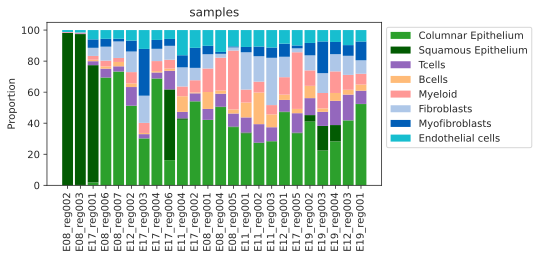

In [33]:
codex_order = data_codex.obs.sort_values(['rediagnosis', 'patient']).index.values
data_codex_ordered = data_codex[codex_order]

# filter out the unclear diagnoses
ddd = ['NE','M','D','T','NS']
data_codex_ordered = data_codex_ordered[data_codex_ordered.obs.rediagnosis.isin(ddd)]

fig = viz.stacked_barplot(data_codex_ordered, 
                          feature_name="samples", 
                          figsize=(6,3), 
                          cmap=cmap_reordered_by_consensus,
                         ); 
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/codex_scrnaseq_compare_CODEX_samples.svg')

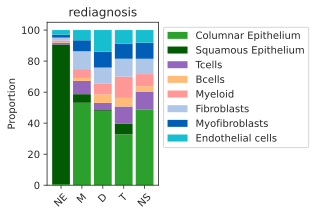

In [34]:
set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_codex_ordered, 
                          feature_name="rediagnosis", 
#                           level_order=ddd, 
                          cmap=cmap_reordered_by_consensus, 
                          figsize=(2,3))
fig.figure.savefig(f'{plotfolder}/codex_scrnaseq_compare_CODEX_diag.svg')